In [ ]:
Freddie Mac dataset with 20 years of mortgage history. The goal is to use H2O-3 to predict the interest rate for each loan, using XGBoost and Deep Learning models. 

In [1]:

# Import libraries 
import os
import h2o
import matplotlib as plt
%matplotlib inline

# Import Estimators
from h2o.estimators.deeplearning import H2ODeepLearningEstimator as H2ODL 
from h2o.estimators import H2OXGBoostEstimator as H2OXGB 
import h2o.grid
from h2o.grid.grid_search import H2OGridSearch

# Start cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.261-b12, mixed mode)
  Starting server from C:\Users\Renzo\AppData\Local\Programs\Python\Python38-32\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Renzo\AppData\Local\Temp\tmp4hgfjrwc
  JVM stdout: C:\Users\Renzo\AppData\Local\Temp\tmp4hgfjrwc\h2o_Renzo_started_from_python.out
  JVM stderr: C:\Users\Renzo\AppData\Local\Temp\tmp4hgfjrwc\h2o_Renzo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/Denver
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,1 month and 7 days
H2O_cluster_name:,H2O_from_python_Renzo_ykzqpy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,247.5 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [3]:
# Import the dataset
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


Rows:500137
Cols:1




,ORIGINAL_INTEREST_RATE
type,real
mins,4.625
mean,7.18268686379932
maxs,11.5
sigma,0.5799408623980559
zeros,0
missing,0
0,7.12
1,6.5
2,6.75


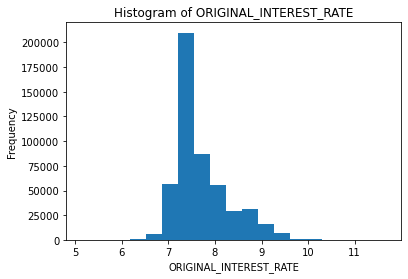

In [15]:
#loan_level.head()
loan_level["ORIGINAL_INTEREST_RATE"].describe()
loan_level["ORIGINAL_INTEREST_RATE"].hist()


In [16]:
# Split data set
# Data manipulation, viz and feature engineering are ignored

train, valid, test = loan_level.split_frame([0.70, 0.15], seed = 42)
print("train: %d  valid: %d  test = %d" % (train.nrows, valid.nrows, test.nrows))

train: 350268  valid: 74971  test = 74898


In [19]:
y = "ORIGINAL_INTEREST_RATE"

ignore = ["ORIGINAL_INTEREST_RATE", 
          "FIRST_PAYMENT_DATE", 
          "MATURITY_DATE", 
          "MORTGAGE_INSURANCE_PERCENTAGE", 
          "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
          "LOAN_SEQUENCE_NUMBER", 
          "PREPAID", 
          "DELINQUENT", 
          "PRODUCT_TYPE"] 

x = list(set(train.names) - set(ignore))

In [33]:
# Build a Deep learning Model
dl = H2ODL(seed = 42, model_id = 'DL',
                              nfolds = 0,
                              keep_cross_validation_predictions = False)
                              
%time dl.train(x = x, y = y, training_frame = train, validation_frame = valid)

dl


deeplearning Model Build progress: |██████████████████████████████████████| 100%
Wall time: 3min 33s
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DL


Status of Neuron Layers: predicting ORIGINAL_INTEREST_RATE, regression, gaussian distribution, Quadratic loss, 73,601 weights/biases, 880.4 KB, 3,598,847 training samples, mini-batch size 1


,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,165,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0560902,0.2134764,0.0,-0.0131039,0.1637114,0.0164139,0.2118216
,3,200,Rectifier,0.0,0.0,0.0,0.0688528,0.0622970,0.0,-0.0512214,0.1328586,0.0234843,0.4892665
,4,1,Linear,,0.0,0.0,0.0012567,0.0008523,0.0,-0.0023225,0.0674174,0.4988078,0.0000000




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.19105146410035348
RMSE: 0.43709434233395594
MAE: 0.3127416719586034
RMSLE: 0.05179466256345663
Mean Residual Deviance: 0.19105146410035348

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.1982688589225402
RMSE: 0.4452739144869596
MAE: 0.3182916473000983
RMSLE: 0.052697079910886846
Mean Residual Deviance: 0.1982688589225402

Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
,2020-10-10 22:11:24,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2020-10-10 22:11:52,41.540 sec,7975 obs/sec,0.2848819,1,99785.0,0.4857329,0.2359364,0.3579536,0.2818630,0.4910408,0.2411211,0.3608821,0.2778305
,2020-10-10 22:12:12,1 min 1.280 sec,13227 obs/sec,1.1414117,4,399800.0,0.4789232,0.2293674,0.3406801,0.3018577,0.4827282,0.2330265,0.3435474,0.3020740
,2020-10-10 22:12:33,1 min 22.720 sec,16072 obs/sec,2.2806994,8,798856.0,0.5238340,0.2744020,0.3871994,0.1647825,0.5254308,0.2760775,0.3870888,0.1731342
,2020-10-10 22:12:53,1 min 42.308 sec,17797 obs/sec,3.4232531,12,1199056.0,0.4926414,0.2426955,0.3624376,0.2612899,0.4934152,0.2434586,0.3631334,0.2708295
,2020-10-10 22:13:16,2 min 5.290 sec,19206 obs/sec,4.8483675,17,1698228.0,0.4455764,0.1985383,0.3095606,0.3956944,0.4521042,0.2043982,0.3149553,0.3878171
,2020-10-10 22:13:38,2 min 27.518 sec,20204 obs/sec,6.2769108,22,2198601.0,0.4370943,0.1910515,0.3127417,0.4184827,0.4452739,0.1982689,0.3182916,0.4061750
,2020-10-10 22:14:00,2 min 49.441 sec,20937 obs/sec,7.7044349,27,2698617.0,0.4468939,0.1997142,0.3165176,0.3921153,0.4536626,0.2058098,0.3213058,0.3835895
,2020-10-10 22:14:21,3 min 10.577 sec,21598 obs/sec,9.1331381,32,3199046.0,0.5002505,0.2502506,0.3692878,0.2382940,0.5042829,0.2543013,0.3711576,0.2383551
,2020-10-10 22:14:38,3 min 27.699 sec,22023 obs/sec,10.2745526,36,3598847.0,0.4522082,0.2044923,0.3161563,0.3775719,0.4609578,0.2124821,0.3228316,0.3636055



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
"SELLER_NAME.NORWESTMORTGAGE,INC",1.0,1.0,0.0128198
SELLER_NAME.Other sellers,0.8615196,0.8615196,0.0110445
"SELLER_NAME.BANKOFAMERICA,NA",0.8316983,0.8316983,0.0106622
SELLER_NAME.WELLSFARGOHOMEMORTGA,0.8166284,0.8166284,0.0104690
"SERVICER_NAME.BANKOFAMERICA,NA",0.7942865,0.7942865,0.0101826
---,---,---,---
PROPERTY_TYPE.missing(NA),0.0,0.0,0.0
CHANNEL.missing(NA),0.0,0.0,0.0
LOAN_PURPOSE.missing(NA),0.0,0.0,0.0
OCCUPANCY_STATUS.missing(NA),0.0,0.0,0.0


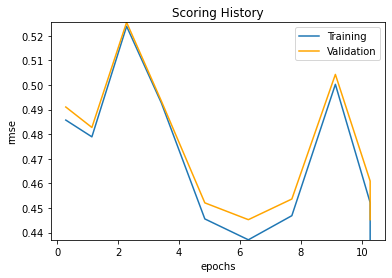

epochs =  {&#39;default&#39;: 10.0, &#39;actual&#39;: 10.0, &#39;input&#39;: 10.0}


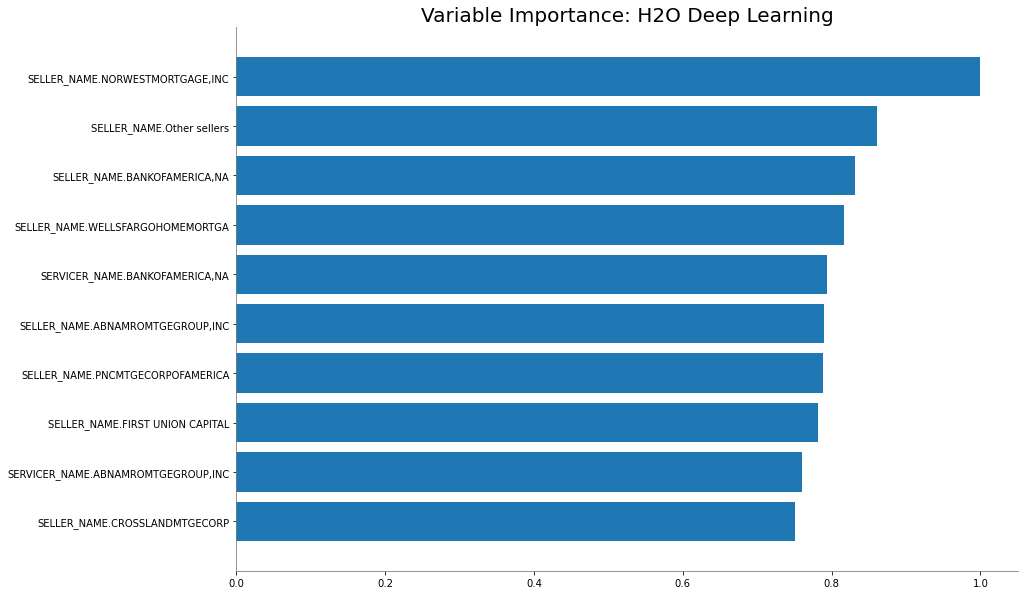

In [36]:
# Model overview
dl.plot()
print("epochs = ", dl.params["epochs"])
dl.varimp_plot()

#Save the model performance
default_dl_per = dl.model_performance(valid)

In [37]:
# Tune the Deep Learning model with GridSearch

dl = H2ODL(seed = 42,
           model_id = "DL_tuned",
           nfolds = 0,
           keep_cross_validation_predictions  = False,
           epochs = 10,
           activation = "rectifier_with_dropout",
           stopping_rounds = 5,
           stopping_tolerance = 1e-3,
           stopping_metric = "rmse")

hyper_params = {
    "hidden": [[100, 100], [165,165], [200, 200], [330, 330], [165, 200]],
    "hidden_dropout_ratios": [[0,0], [0.01, 0.01], [0.15, 0.15], [0.30, 0.30], [0.5, 0.5]]
}

search_criteria_tune = {
    "strategy": "RandomDiscrete",
    "max_runtime_secs": 900,
    "max_models": 100,
    "seed": 42
}

dl_grid = H2OGridSearch(model = dl,
                        hyper_params = hyper_params,
                        grid_id = "random_dl_grid",
                        search_criteria = search_criteria_tune)

%time dl_grid.train(x = x, y = y, training_frame = train, validation_frame = valid)


hidden_per = dl_grid.get_grid(sort_by = "rmse", decreasing = False)
hidden_per.sorted_metric_table()

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
Wall time: 15min 4s

Hyper-Parameter Search Summary: ordered by increasing rmse


,hidden,hidden_dropout_ratios,model_ids,rmse
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_5,0.4420332
,"[100, 100]","[0.5, 0.5]",random_dl_grid_model_2,0.4499039
,"[165, 165]","[0.5, 0.5]",random_dl_grid_model_1,0.4502227
,"[330, 330]","[0.3, 0.3]",random_dl_grid_model_6,0.4566039
,"[165, 165]","[0.0, 0.0]",random_dl_grid_model_4,0.4606420
,"[165, 200]","[0.0, 0.0]",random_dl_grid_model_3,0.4627119


In [38]:
dl = H2ODL(seed = 42,
           model_id = "DL_tuned",
           nfolds = 0,
           keep_cross_validation_predictions  = False,
           epochs = 10,
           hidden = [200, 200],
           hidden_dropout_ratios = [0.01, 0.01],
           activation = "rectifier_with_dropout",
           stopping_rounds = 3,
           stopping_tolerance = 1e-3,
           stopping_metric = "rmse",
           adaptive_rate = True)


hyper_params = {
                'max_w2'  : [1e38, 1e35, 1e36],
                'l2'      : [1e-7, 1e-6, 1e-5, 1e-4],
               }


search_criteria_tune = {
    "strategy": "RandomDiscrete",
    "max_runtime_secs": 900,
    "max_models": 100,
    "seed": 42
}

dl_grid = H2OGridSearch(model = dl,
                        hyper_params = hyper_params,
                        grid_id = "random_dl_grid",
                        search_criteria = search_criteria_tune)

%time dl_grid.train(x = x, y = y, training_frame = train, validation_frame = valid)


hidden_per = dl_grid.get_grid(sort_by = "rmse", decreasing = False)
hidden_per.sorted_metric_table()


deeplearning Grid Build progress: |███████████████████████████████████████| 100%
Wall time: 15min 4s

Hyper-Parameter Search Summary: ordered by increasing rmse


,hidden,hidden_dropout_ratios,model_ids,rmse
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_7,0.4379235
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_9,0.4393475
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_5,0.4420332
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_8,0.4440946
,"[100, 100]","[0.5, 0.5]",random_dl_grid_model_2,0.4499039
,"[165, 165]","[0.5, 0.5]",random_dl_grid_model_1,0.4502227
,"[330, 330]","[0.3, 0.3]",random_dl_grid_model_6,0.4566039
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_10,0.4571627
,"[165, 165]","[0.0, 0.0]",random_dl_grid_model_4,0.4606420
,"[165, 200]","[0.0, 0.0]",random_dl_grid_model_3,0.4627119


In [40]:
dl_perf = dl_grid.get_grid(sort_by='rmse', decreasing=False)
dl_perf.sorted_metric_table()


Hyper-Parameter Search Summary: ordered by increasing rmse


,hidden,hidden_dropout_ratios,model_ids,rmse
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_7,0.4379235
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_9,0.4393475
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_5,0.4420332
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_8,0.4440946
,"[100, 100]","[0.5, 0.5]",random_dl_grid_model_2,0.4499039
,"[165, 165]","[0.5, 0.5]",random_dl_grid_model_1,0.4502227
,"[330, 330]","[0.3, 0.3]",random_dl_grid_model_6,0.4566039
,"[200, 200]","[0.01, 0.01]",random_dl_grid_model_10,0.4571627
,"[165, 165]","[0.0, 0.0]",random_dl_grid_model_4,0.4606420
,"[165, 200]","[0.0, 0.0]",random_dl_grid_model_3,0.4627119


In [ ]:
dl_grid = H2OGridSearch(model = dl,
                        hyper_params = hyper_params,
                        grid_id = "random_dl_grid",
                        search_criteria = search_criteria_tune)

%time dl_grid.train(x = x, y = y, training_frame = train, validation_frame = valid)


hidden_per = dl_grid.get_grid(sort_by = "rmse", decreasing = False)
hidden_per.sorted_metric_table() 